In [76]:
import numpy as np
from pathlib import Path
import librosa
import librosa.display
from collections import defaultdict
import soundfile as sf
import tqdm
import os
from multiprocessing import Pool, cpu_count
import cv2
from matplotlib import pyplot as plt
import IPython
import pandas as pd
import scipy.signal
import time
from datetime import timedelta as td
import noisereduce as nr
from PIL import Image
from pathlib import Path
from IPython.display import Audio, IFrame, display
from scipy import signal
import random
from scipy.ndimage import maximum_filter1d
import pickle
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_tensor

%matplotlib inline

In [2]:
INPUT =  "../input/resample_sound_2"
OUTPUT = "../output/train_img_8"
SAMPLE_RATE = 32_000
NUM_WORKERS = cpu_count()
THESHOLD = 0.001

SIGNAL_LEN = SAMPLE_RATE * 5

print(NUM_WORKERS)

12


In [3]:
def audio_to_spec(audio):
    spec = librosa.power_to_db(
        librosa.feature.melspectrogram(audio, sr=SAMPLE_RATE, fmin=20, fmax=16000, n_mels=128)
    )
    return spec.astype(np.float32)
    
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

#def envelope(y, rate, threshold):
#    mask = []
#    y = pd.Series(y).apply(np.abs)
#    y_mean = y.rolling(window=int(rate/20),min_periods=1,center=True).max()
#    for mean in y_mean:
#        if mean > threshold:
#            mask.append(True)
#        else:
#            mask.append(False)
#    return mask, y_mean

def audio2cut_pict(path):
    x, _ = librosa.load(path=path, sr=SAMPLE_RATE, mono=True)
    x_spec_lst = [audio_to_spec(x[idx*SIGNAL_LEN:(idx+1)*SIGNAL_LEN]) for idx in range(len(x)//(SIGNAL_LEN))]
    for idx, x_spec in enumerate(x_spec_lst):
        cv2.imwrite(f"{OUTPUT}/{path.parent.name}/{path.name}_{idx}.jpg", mono_to_color(x_spec))

In [4]:
train_df = pd.read_csv("../input/train.csv")

### get high quarity

In [ ]:
_df = train_df[train_df["secondary_labels"] == "[]"]
_df = _df[_df["rating"] > 3.5]
train_df_2 = _df.reset_index(drop=True) 
path_lst = [filename.split(".")[0]+".wav" for filename in train_df_2["filename"]]
train_df_2.head(1)

In [ ]:
for directory in Path(INPUT).iterdir():
    if directory.name in [".DS_Store"]:
        continue
    dir_paths = [f for f in directory.iterdir() if f.name not in [".DS_Store", "train_mod.csv"]]
    for dname in tqdm.tqdm_notebook(dir_paths, total=len(dir_paths)):
        !mkdir -p "{OUTPUT}/{dname.name}"
        
        file_paths = [f for f in dname.iterdir() if f.name != ".DS_Store"]
        file_paths = [path for path in file_paths if path.name in path_lst]
        
        with Pool(NUM_WORKERS // 2) as p:
            p.map(audio2cut_pict, file_paths)

### no call

In [ ]:
def draw_pict_nocall(path):
    x, _ = librosa.load(path=path, sr=SAMPLE_RATE, mono=True)
    mask, env = envelope(x, SAMPLE_RATE, THESHOLD)
    nocall = np.logical_not(mask)
    if sum(nocall) == 0:
        return

    x = x[nocall]
    x_spec_lst = [audio_to_spec(x[idx*SIGNAL_LEN:(idx+1)*SIGNAL_LEN]) for idx in range(len(x)//(SIGNAL_LEN))]
    for idx, x_spec in enumerate(x_spec_lst):
        cv2.imwrite(f"{OUTPUT}/nocall_{path.name}_{idx}.jpg", mono_to_color(x_spec))

In [ ]:
train_df_3 = train_df[train_df["rating"] <= 3.5].reset_index(drop=True)
path_lst_2 = [filename.split(".")[0]+".wav" for filename in train_df_3["filename"]]
train_df_3.head(1)

In [ ]:
!mkdir -p "{OUTPUT}"

for directory in Path(INPUT).iterdir():
    if directory.name in [".DS_Store"]:
        continue
    dir_paths = [f for f in directory.iterdir() if f.name not in [".DS_Store", "train_mod.csv"]]
    for dname in tqdm.tqdm_notebook(dir_paths, total=len(dir_paths)):
        file_paths = [f for f in dname.iterdir() if f.name != ".DS_Store"]
        file_paths = [path for path in file_paths if path.name in path_lst_2]
        with Pool(NUM_WORKERS // 2) as p:
            p.map(draw_pict_nocall, file_paths)

### Denoise

In [5]:
def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()


def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    if verbose:
        print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

def envelope(y, rate, threshold):
    y_mean = maximum_filter1d(np.abs(y), mode="constant", size=rate//20)
    mask = [mean > threshold for mean in y_mean]
    return mask

def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

def denoise_and_filter(path):
    x, _ = librosa.load(path=path, sr=SAMPLE_RATE, mono=True)
    xf = f_high(x, SAMPLE_RATE)
    mask = envelope(xf, SAMPLE_RATE, 0.02)
    try:
        x_denoise = nr.reduce_noise(audio_clip=xf, noise_clip=xf[np.logical_not(mask)], verbose=False)
    except:
        return xf
    return x_denoise

def deoise2pict(path):
    x = denoise_and_filter(path)
    x_spec = audio_to_spec(x)
    x_spec = x_spec[35:, :]
    img = mono_to_color(x_spec)
    cv2.imwrite(f"{OUTPUT}/{path.parent.name}/{path.name}.jpg", img)

In [6]:
count = 0 
for directory in Path(INPUT).iterdir():
    count += 1
    if count < 5:
        continue
    if directory.name in [".DS_Store"]:
        continue
    dir_paths = [f for f in directory.iterdir() if f.name not in [".DS_Store", "train_mod.csv"]]
    for dname in tqdm.tqdm_notebook(dir_paths, total=len(dir_paths)):
        !mkdir -p "{OUTPUT}/{dname.name}"
        
        file_paths = [f for f in dname.iterdir() if f.name != ".DS_Store"]

        with Pool(NUM_WORKERS // 2) as p:
            p.map(deoise2pict, file_paths)

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


### no call open

In [21]:
!mkdir -p "{OUTPUT}"
for path in Path("../input/no_call_sample").iterdir():
    x, _ = librosa.load(path=path, sr=SAMPLE_RATE, mono=True)
    x_spec = audio_to_spec(x)
    cv2.imwrite(f"{OUTPUT}/{path.name}.jpg", mono_to_color(x_spec))

### Detection

In [24]:
for directory in Path(INPUT).iterdir():
    if directory.name in [".DS_Store"]:
        continue
    dir_paths = [f for f in directory.iterdir() if f.name not in [".DS_Store", "train_mod.csv"]]
    for dname in tqdm.tqdm_notebook(dir_paths, total=len(dir_paths)):
        !mkdir -p "{OUTPUT}/{dname.name}"
        
        file_paths = [f for f in dname.iterdir() if f.name != ".DS_Store"]
        
        #with Pool(NUM_WORKERS // 2) as p:
        #    p.map(audio2cut_pict, file_paths)
        break
    break

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [29]:
time_df = pd.read_csv("../input/timestamps-train-cornell-birds.csv")
time_df.head()

,bird,file,start,duration
0,aldfly,XC134874.mp3,4.7,0.4
1,aldfly,XC134874.mp3,8.4,0.4
2,aldfly,XC134874.mp3,14.4,0.4
3,aldfly,XC135454.mp3,0.8,0.7
4,aldfly,XC135454.mp3,7.4,0.4


In [96]:
path = file_paths[-1]

In [97]:
    x, _ = librosa.load(path=path, sr=SAMPLE_RATE, mono=True)
    x_spec = audio_to_spec(x)
    
    _time_df = time_df[time_df["file"] == path.name.replace("wav", "mp3")]
    mask = np.zeros(x.shape[0])

In [98]:
x_spec.shape

(128, 1444)

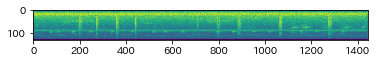

In [99]:
plt.imshow(x_spec)

In [100]:
path.name.replace("wav", "mp3")

'XC288989.mp3'

In [101]:
for s, d in _time_df[["start", "duration"]].values:
    mask[int(s*SAMPLE_RATE):int((s+d)*SAMPLE_RATE)] = 1

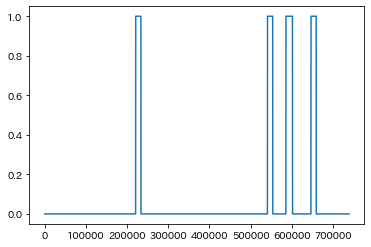

In [102]:
plt.plot(mask)

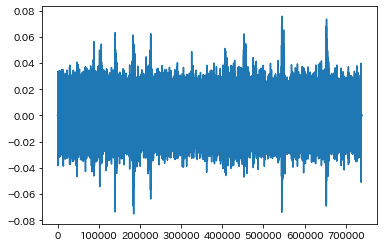

In [103]:
plt.plot(x)

In [104]:
IPython.display.Audio(data=x, rate=SAMPLE_RATE)

## png

In [5]:
def audio2png(path):
    x, _ = librosa.load(path=path, sr=SAMPLE_RATE, mono=True)
    x_spec = audio_to_spec(x)
    cv2.imwrite(f"{OUTPUT}/{path.parent.name}/{path.name}.png", mono_to_color(x_spec))

In [6]:
for directory in Path(INPUT).iterdir():
    if directory.name in [".DS_Store"]:
        continue
    dir_paths = [f for f in directory.iterdir() if f.name not in [".DS_Store", "train_mod.csv"]]
    for dname in tqdm.tqdm_notebook(dir_paths, total=len(dir_paths)):
        !mkdir -p "{OUTPUT}/{dname.name}"
        file_paths = [f for f in dname.iterdir() if f.name != ".DS_Store"]
        with Pool(NUM_WORKERS // 2) as p:
            p.map(audio2png, file_paths)

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [12]:
for directory in Path(OUTPUT).iterdir():
    if directory.name == ".DS_Store":
        continue
    file_paths = [f for f in directory.iterdir() if f.name != ".DS_Store"]
    for path in file_paths:
        try:
            with open(path, 'rb') as f: img = Image.open(f)
        except:
            print(path)
            #!rm {path}

In [11]:
!mkdir "{OUTPUT}/0_no_call"
for path in Path("../input/no_call_sample").iterdir():
    x, _ = librosa.load(path=path, sr=SAMPLE_RATE, mono=True)
    x_spec = audio_to_spec(x)
    cv2.imwrite(f"{OUTPUT}/0_no_call/{path.name}.png", mono_to_color(x_spec))